<a href="https://colab.research.google.com/github/OreoKitkat/Study_Group/blob/main/sb3_vecenv_tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Vector Environments in Stable Baselines3

## Overview

This tutorial provides an in-depth analysis of vectorized environments in reinforcement learning, focusing on:
- **Three ways to create vectorized environments**:
  1. `make_vec_env()` - The recommended wrapper function with automatic seed management
  2. `DummyVecEnv([lambda: ...])` - Manual creation without seed control
  3. Custom factory functions - Full control over seeding and initialization
- Performance characteristics and trade-offs
- Implementation differences between DummyVecEnv and SubprocVecEnv
- Algorithm-specific benefits
- Connections to multi-agent RL (MARL)

**Target Audience**: Graduate researchers with RL background  
**Based on**: [Official SB3 Multiprocessing Tutorial](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/3_multiprocessing.ipynb)

## 📦 Installation and Setup

In [1]:
# Install required packages
!pip install stable-baselines3[extra] gymnasium matplotlib numpy -q
!pip install sb3-contrib -q  # For TRPO algorithm
!pip install torch -q  # For QMIX demonstration

print("✅ Packages installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import all required libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import A2C, PPO, DQN, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

# Try importing additional algorithms
try:
    from sb3_contrib import TRPO
    HAS_CONTRIB = True
    print("✅ sb3-contrib available - TRPO can be tested")
except:
    HAS_CONTRIB = False
    print("ℹ️  sb3-contrib not available - TRPO will be skipped")

✅ sb3-contrib available - TRPO can be tested


## 🎯 Opening Hook: The Speed Difference

Let's start with a practical demonstration of why vectorized environments matter.

### 🌟 Most Important Takeaway
**If you remember only one thing from this tutorial:**  
Use `make_vec_env()` - it's the easiest way to create vectorized environments with proper seed management!


```python
# Instead of this:
env = gym.make("CartPole-v1")

# Use this:
vec_env = make_vec_env("CartPole-v1", n_envs=4, seed=42)
```



We will be using the Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)



In [3]:
# Quick demonstration of speedup
print("🏁 Vector Environment Speedup Demo")
print("=" * 50)

# Single environment
env = gym.make("CartPole-v1")

# Vectorized environment using make_vec_env (recommended approach!)
# Note: make_vec_env automatically handles seed management by adding rank to base seed
vec_env = make_vec_env("CartPole-v1", n_envs=4, seed=42)

# Single env timing
model = A2C("MlpPolicy", env, verbose=0)
start = time.time()
model.learn(5000)
single_time = time.time() - start

# Vector env timing
model = A2C("MlpPolicy", vec_env, verbose=0)
start = time.time()
model.learn(5000)
vec_time = time.time() - start

print(f"\n📊 Results:")
print(f"  Single environment: {single_time:.2f}s")
print(f"  4 environments:     {vec_time:.2f}s")
print(f"  Speedup:            {single_time/vec_time:.2f}x")
print(f"\n✅ Created with make_vec_env - automatic seed management included!")

# Always close environments to free resources
env.close()
vec_env.close()

🏁 Vector Environment Speedup Demo

📊 Results:
  Single environment: 9.51s
  4 environments:     2.38s
  Speedup:            3.99x

✅ Created with make_vec_env - automatic seed management included!


## 🔍 DummyVecEnv vs SubprocVecEnv: Internal Mechanics

### Method 2: Manual Creation with DummyVecEnv or SubprocVecEnv

The second way to create vectorized environments is using `DummyVecEnv(env_fns)` or `SubprocVecEnv(env_fns)` directly, where `env_fns: (list[Callable[[], Env]])` is a list of functions that return environments to vectorize:

```python
# Manual creation - NO automatic seed management!
vec_env = DummyVecEnv([lambda: gym.make("CartPole-v1") for _ in range(4)])
# vec_env = SubprocVecEnv([lambda: gym.make("CartPole-v1") for _ in range(4)])
```

⚠️ **Important**: This approach does NOT handle seeds automatically!
- Environments use uncontrolled random initialization
- No guarantee of diverse initial states between environments
- Results are not reproducible across runs
- Environments might share the global random state, leading to correlated randomness



### Internal Implementation Differences

#### 📘 DummyVecEnv - Truly Sequential
- Runs in the **main process** on a **single thread**
- **Sequential execution** (from SB3 source code):
  ```python
  # Simplified from stable_baselines3/common/vec_env/dummy_vec_env.py
  def step(self, actions):
      for i in range(self.num_envs):
          obs, reward, done, info = self.envs[i].step(actions[i])
          # Process results sequentially
      return obs_list, reward_list, done_list, info_list
  ```
- **No parallelism**: Environments execute one after another, not simultaneously
- **CPU utilization**: Uses only one CPU core, no matter how many environments
- Simple and debuggable
- Best for lightweight environments
- **Closing**: Less critical, mainly frees memory and rendering resources

#### 📙 SubprocVecEnv - True Parallelism
- Each environment runs in a **separate OS process**
- **Parallel execution** (from SB3 source code):
  ```python
  # Simplified from stable_baselines3/common/vec_env/subproc_vec_env.py
  def step(self, actions):
      # Send actions to all processes simultaneously
      for pipe, action in zip(self.remotes, actions):
          pipe.send(('step', action))  # Non-blocking
      
      # Wait for all processes to complete (blocking)
      results = [pipe.recv() for pipe in self.remotes]
      return results
  ```
- **True parallelism**: Each process can run on different CPU cores
- **CPU utilization**: Can use multiple CPU cores effectively
- Communication overhead via pipes
- Best for computationally expensive environments
- **Closing**: CRITICAL! Must terminate spawned processes to prevent zombies




### 🤔 Question for the audience:
**'Which do you think is faster for CartPole: DummyVecEnv or SubprocVecEnv?'**

Let's find out empirically:

In [4]:
# Timing comparison
def time_env_step(env_class, n_envs=4, n_steps=1000):
    """Time the step function overhead"""
    if env_class == DummyVecEnv:
        env = DummyVecEnv([lambda: gym.make("CartPole-v1") for _ in range(n_envs)])
    else:
        env = SubprocVecEnv([lambda: gym.make("CartPole-v1") for _ in range(n_envs)],
                            start_method='spawn')

    env.reset()
    start = time.time()

    for _ in range(n_steps):
        actions = [env.action_space.sample() for _ in range(n_envs)]
        env.step(actions)

    elapsed = time.time() - start
    env.close()  # Important: Always close environments, especially SubprocVecEnv!
    return elapsed

print("⏱️  Timing 1000 steps with 4 environments:")
dummy_time = time_env_step(DummyVecEnv)
subproc_time = time_env_step(SubprocVecEnv)

print(f"  DummyVecEnv:   {dummy_time:.3f}s")
print(f"  SubprocVecEnv: {subproc_time:.3f}s")
print(f"\n🎯 Winner for CartPole: {'DummyVecEnv' if dummy_time < subproc_time else 'SubprocVecEnv'}!")
print("\n💡 Why? CartPole is too simple - communication overhead > computation time!")

⏱️  Timing 1000 steps with 4 environments:
  DummyVecEnv:   0.134s
  SubprocVecEnv: 0.984s

🎯 Winner for CartPole: DummyVecEnv!

💡 Why? CartPole is too simple - communication overhead > computation time!


## 🎲 Critical: Proper Seeding for Reproducibility

### Method 3: Custom Factory Functions with Full Control

The third way to create vectorized environments is using custom factory functions. This gives you:
- ✅ Full control over seeding
- ✅ Reproducible results
- ✅ Guaranteed diversity between environments

This approach is equivalent to what `make_vec_env` does internally!

### The Problem: Without Unique Seeds

When using the same seed for all environments, they become **perfectly synchronized**, eliminating the diversity benefit of vectorization:

In [5]:
# Demonstrate the importance of unique seeds
print("🎲 SEED DEMONSTRATION")
print("=" * 50)


# Wrong way - same seed
def make_env_same_seed(env_id, seed=42):
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed)  # Same seed!
        return env
    return _init

# Right way - different seeds
def make_env(env_id, rank, seed=42):
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed + rank)  # Different seeds!
        return env
    set_random_seed(seed)
    return _init

# Test with same seeds
print("\n❌ With SAME seeds:")
vec_env_same = DummyVecEnv([make_env_same_seed("CartPole-v1") for _ in range(3)])
obs = vec_env_same.reset()
print(f"Initial observations:\n{obs}")
print("Notice: All observations are IDENTICAL!")

# Take a step
actions = [1, 1, 1]  # Same action
obs, _, _, _ = vec_env_same.step(actions)
print(f"\nAfter same action:\n{obs}")
print("Still IDENTICAL - no diversity!")
vec_env_same.close()

# Test with different seeds
print("\n✅ With DIFFERENT seeds (rank-based):")
vec_env_diff = DummyVecEnv([make_env("CartPole-v1", i, 42) for i in range(3)])
obs = vec_env_diff.reset()
print(f"Initial observations:\n{obs}")
print("Now they're DIFFERENT - better exploration!")
vec_env_diff.close()

print("\n💡 Key insight: rank + seed ensures reproducibility AND diversity!")

🎲 SEED DEMONSTRATION

❌ With SAME seeds:
Initial observations:
[[-0.04058227  0.04756223  0.02611397  0.02860643]
 [-0.04058227  0.04756223  0.02611397  0.02860643]
 [-0.04058227  0.04756223  0.02611397  0.02860643]]
Notice: All observations are IDENTICAL!

After same action:
[[-0.03963102  0.24230015  0.0266861  -0.25572422]
 [-0.03963102  0.24230015  0.0266861  -0.25572422]
 [-0.03963102  0.24230015  0.0266861  -0.25572422]]
Still IDENTICAL - no diversity!

✅ With DIFFERENT seeds (rank-based):
Initial observations:
[[-0.04058227  0.04756223  0.02611397  0.02860643]
 [ 0.0087143  -0.02752948  0.02517923 -0.02363078]
 [-0.03376829  0.03572937 -0.03369547 -0.01620381]]
Now they're DIFFERENT - better exploration!

💡 Key insight: rank + seed ensures reproducibility AND diversity!


## 📊 Comprehensive Performance Analysis

Following the official SB3 tutorial approach, we'll conduct multiple experiments to analyze the trade-offs between training speed and sample efficiency.

In [6]:
# Following the official tutorial structure with comments
env_id = "CartPole-v1"
PROCESSES_TO_TEST = [1, 2, 4, 8, 16]
NUM_EXPERIMENTS = 3  # Multiple runs for stability
TRAIN_STEPS = 5000
EVAL_EPS = 20
ALGO = A2C  # A2C is a synchronous version of A3C designed for vectorized environments

# Create evaluation environment
eval_env = gym.make(env_id)

# Storage for results
reward_averages = []
reward_std = []
training_times = []
total_procs = 0  # Accumulated for unique seeding

print("🔬 PERFORMANCE ANALYSIS")
print("=" * 50)
print(f"Algorithm: {ALGO.__name__}")
print(f"Environment: {env_id}")
print(f"Experiments per setting: {NUM_EXPERIMENTS}")
print(f"Training steps: {TRAIN_STEPS}")

for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f"\n📊 Testing with {n_procs} process(es)...")

    # IMPORTANT: From the official tutorial - A2C implementation scales linearly
    # with the number of workers (i.e. environments), see original A3C paper
    if n_procs == 1:
        # Single process
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        # Multiple processes - using DummyVecEnv with manual seed management
        # Note: make_vec_env(env_id, n_envs=n_procs, seed=42) would be equivalent
        # and simpler, handling the seed management automatically
        train_env = DummyVecEnv(
            [make_env(env_id, i + total_procs) for i in range(n_procs)]
        )

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # Reset environment
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)

        # Time training
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)

        # Evaluate
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    # Close environment
    train_env.close()

    # Store statistics
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

    print(f"  Mean reward: {np.mean(rewards):.1f} ± {np.std(rewards):.1f}")
    print(f"  Mean time: {np.mean(times):.2f}s")

eval_env.close()

🔬 PERFORMANCE ANALYSIS
Algorithm: A2C
Environment: CartPole-v1
Experiments per setting: 3
Training steps: 5000

📊 Testing with 1 process(es)...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Mean reward: 412.7 ± 114.7
  Mean time: 9.75s

📊 Testing with 2 process(es)...
  Mean reward: 158.7 ± 138.7
  Mean time: 5.27s

📊 Testing with 4 process(es)...
  Mean reward: 299.9 ± 109.8
  Mean time: 2.53s

📊 Testing with 8 process(es)...
  Mean reward: 87.5 ± 34.5
  Mean time: 1.51s

📊 Testing with 16 process(es)...
  Mean reward: 59.1 ± 25.1
  Mean time: 0.74s



📈 Results Summary:
Processes: [1, 2, 4, 8, 16]
FPS: ['513', '949', '1976', '3316', '6771']
Rewards: ['412.7', '158.7', '299.9', '87.5', '59.1']


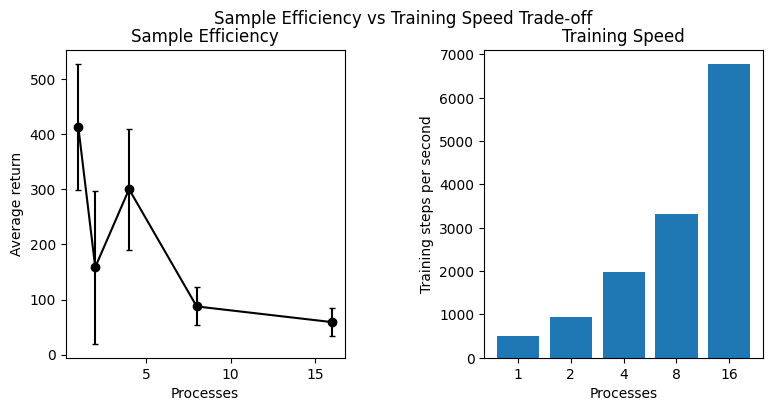

In [7]:
# Plotting results - following official tutorial style
def plot_training_results(training_steps_per_second, reward_averages, reward_std):
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)

    # Performance plot
    plt.subplot(1, 2, 1)
    plt.errorbar(
        PROCESSES_TO_TEST,
        reward_averages,
        yerr=reward_std,
        capsize=2,
        c="k",
        marker="o",
    )
    plt.xlabel("Processes")
    plt.ylabel("Average return")
    plt.title("Sample Efficiency")

    # Speed plot
    plt.subplot(1, 2, 2)
    plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
    plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
    plt.xlabel("Processes")
    plt.ylabel("Training steps per second")
    plt.title("Training Speed")

    plt.suptitle("Sample Efficiency vs Training Speed Trade-off")
    plt.show()

# Calculate steps per second
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

print("\n📈 Results Summary:")
print(f"Processes: {PROCESSES_TO_TEST}")
print(f"FPS: {[f'{fps:.0f}' for fps in training_steps_per_second]}")
print(f"Rewards: {[f'{r:.1f}' for r in reward_averages]}")

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## ⏱️ Fixed Wall-Clock Time Analysis

**Key Trade-off**: More environments = faster training but potentially worse sample efficiency per step.

However, when we fix the **wall-clock time**, the story changes:

⏱️  FIXED TIME ANALYSIS
Fixed time per experiment: 10s
Steps per configuration: [5128, 9485, 19763, 33164, 67714]

🔄 1 process(es), 5128 steps...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Mean reward: 185.2 ± 66.0
  Actual time: 9.86s

🔄 2 process(es), 9485 steps...
  Mean reward: 332.9 ± 131.5
  Actual time: 9.55s

🔄 4 process(es), 19763 steps...
  Mean reward: 370.0 ± 159.3
  Actual time: 10.00s

🔄 8 process(es), 33164 steps...
  Mean reward: 321.5 ± 134.1
  Actual time: 9.10s

🔄 16 process(es), 67714 steps...
  Mean reward: 272.2 ± 168.5
  Actual time: 10.70s


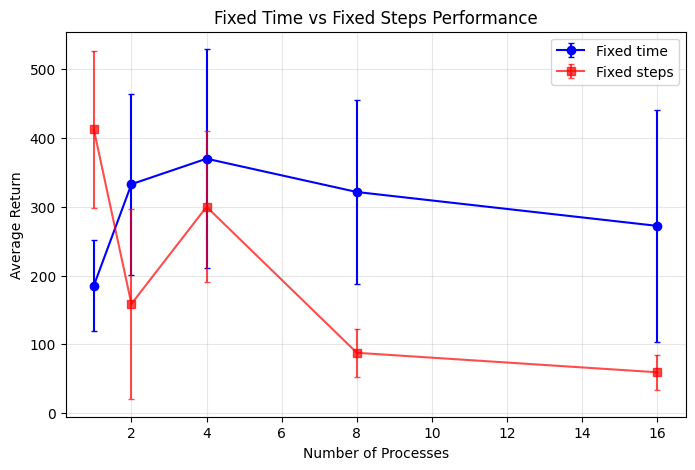


💡 Key Insight: With fixed wall-clock time, more environments often win!


In [8]:
# Fixed time experiment - crucial for understanding trade-offs
SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]

print("⏱️  FIXED TIME ANALYSIS")
print("=" * 50)
print(f"Fixed time per experiment: {SECONDS_PER_EXPERIMENT}s")
print(f"Steps per configuration: {steps_per_experiment}")

fixed_time_rewards = []
fixed_time_std = []
actual_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print(f"\n🔄 {n_procs} process(es), {train_steps} steps...")

    if n_procs == 1:
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        # Using manual seed management
        # Equivalent to: train_env = make_vec_env(env_id, n_envs=n_procs, seed=total_procs)
        train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)

        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time() - start)

        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()

    fixed_time_rewards.append(np.mean(rewards))
    fixed_time_std.append(np.std(rewards))
    actual_times.append(np.mean(times))

    print(f"  Mean reward: {np.mean(rewards):.1f} ± {np.std(rewards):.1f}")
    print(f"  Actual time: {np.mean(times):.2f}s")

# Plot fixed time results
plt.figure(figsize=(8, 5))
plt.errorbar(
    PROCESSES_TO_TEST,
    fixed_time_rewards,
    yerr=fixed_time_std,
    capsize=2,
    c="b",
    marker="o",
    label="Fixed time"
)
plt.errorbar(
    PROCESSES_TO_TEST,
    reward_averages,
    yerr=reward_std,
    capsize=2,
    c="r",
    marker="s",
    label="Fixed steps",
    alpha=0.7
)
plt.xlabel("Number of Processes")
plt.ylabel("Average Return")
plt.title("Fixed Time vs Fixed Steps Performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 Key Insight: With fixed wall-clock time, more environments often win!")

## 🎮 Algorithm-Specific Vectorization Benefits

Different algorithms benefit differently from vectorization based on their architectural design:

- **On-policy algorithms** (A2C, PPO, TRPO): Benefit from both speed AND improved gradient estimates
- **Off-policy algorithms** (DQN, SAC): Primarily benefit from faster data collection

Let's analyze these differences empirically with proper statistical averaging:

In [9]:
# Extended algorithm comparison with multiple experiments for stability
algorithms_to_test = {
    "A2C": {"class": A2C, "type": "on-policy", "sync": "synchronous", "n_steps": 5},
    "PPO": {"class": PPO, "type": "on-policy", "sync": "synchronous", "n_steps": 128},
    "DQN": {"class": DQN, "type": "off-policy", "sync": "asynchronous", "buffer_size": 10000},
}

if HAS_CONTRIB:
    algorithms_to_test["TRPO"] = {"class": TRPO, "type": "on-policy", "sync": "synchronous", "n_steps": 128}

print("🎮 ALGORITHM COMPARISON")
print("=" * 50)
print(f"Testing {len(algorithms_to_test)} algorithms with 1 vs 4 environments")
print(f"Training steps: 10000")
print(f"Experiments per setting: 5\n")

algo_results = {}

for algo_name, algo_info in algorithms_to_test.items():
    print(f"\n📊 {algo_name} ({algo_info['type']}, {algo_info['sync']}):")
    print("-" * 50)

    try:
        # Run multiple experiments for stability
        single_times = []
        single_rewards = []
        vec_times = []
        vec_rewards = []

        for exp in range(5):
            # Single environment experiment
            env = gym.make(env_id)
            kwargs = {"verbose": 0}
            if "n_steps" in algo_info:
                kwargs["n_steps"] = algo_info["n_steps"]
            if "buffer_size" in algo_info:
                kwargs["buffer_size"] = algo_info["buffer_size"]
                kwargs["learning_starts"] = 1000

            model = algo_info["class"]("MlpPolicy", env, **kwargs)
            start = time.time()
            model.learn(10000)
            single_times.append(time.time() - start)
            single_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
            single_rewards.append(single_reward)
            env.close()

            # Vector environment experiment
            vec_env = make_vec_env(env_id, n_envs=4, seed=42+exp)
            model = algo_info["class"]("MlpPolicy", vec_env, **kwargs)
            start = time.time()
            model.learn(10000)
            vec_times.append(time.time() - start)
            vec_reward, _ = evaluate_policy(model, vec_env, n_eval_episodes=10)
            vec_rewards.append(vec_reward)
            vec_env.close()

        # Calculate statistics
        avg_single_time = np.mean(single_times)
        avg_single_reward = np.mean(single_rewards)
        std_single_reward = np.std(single_rewards)
        avg_vec_time = np.mean(vec_times)
        avg_vec_reward = np.mean(vec_rewards)
        std_vec_reward = np.std(vec_rewards)

        speedup = avg_single_time / avg_vec_time
        reward_improvement = (avg_vec_reward - avg_single_reward) / avg_single_reward * 100

        algo_results[algo_name] = {
            "speedup": speedup,
            "type": algo_info["type"],
            "sync": algo_info["sync"],
            "single_reward": avg_single_reward,
            "vec_reward": avg_vec_reward,
            "reward_improvement": reward_improvement
        }

        print(f"  Single env: {avg_single_time:.2f}s, reward: {avg_single_reward:.1f} ± {std_single_reward:.1f}")
        print(f"  4 envs:     {avg_vec_time:.2f}s, reward: {avg_vec_reward:.1f} ± {std_vec_reward:.1f}")
        print(f"  Speedup:    {speedup:.2f}x")
        print(f"  Reward improvement: {reward_improvement:+.1f}%")

        # Explain the benefits
        if algo_info["type"] == "on-policy":
            print(f"  💡 Benefits: Fresh data + Better gradient estimates (batch_size = n_steps × n_envs)")
        else:
            print(f"  💡 Benefits: Faster buffer filling + More diverse experiences")

    except Exception as e:
        print(f"  ❌ Error: {e}")

🎮 ALGORITHM COMPARISON
Testing 4 algorithms with 1 vs 4 environments
Training steps: 10000
Experiments per setting: 5


📊 A2C (on-policy, synchronous):
--------------------------------------------------
  Single env: 19.21s, reward: 273.7 ± 132.0
  4 envs:     5.21s, reward: 365.5 ± 124.7
  Speedup:    3.69x
  Reward improvement: +33.5%
  💡 Benefits: Fresh data + Better gradient estimates (batch_size = n_steps × n_envs)

📊 PPO (on-policy, synchronous):
--------------------------------------------------
  Single env: 16.79s, reward: 426.2 ± 73.1
  4 envs:     10.15s, reward: 369.3 ± 122.2
  Speedup:    1.65x
  Reward improvement: -13.3%
  💡 Benefits: Fresh data + Better gradient estimates (batch_size = n_steps × n_envs)

📊 DQN (off-policy, asynchronous):
--------------------------------------------------
  Single env: 10.93s, reward: 12.5 ± 4.2
  4 envs:     2.96s, reward: 9.2 ± 0.1
  Speedup:    3.69x
  Reward improvement: -26.3%
  💡 Benefits: Faster buffer filling + More diverse exper



### How Vectorization Improves Gradient Estimates

**Evidence from the A3C paper** (Mnih et al., 2016):
> "Using parallel actor-learners has a stabilizing effect on training... different actors are likely to be exploring different parts of the environment."

**Concrete mechanism**:
```python
# Single environment gradient:
gradient = compute_gradient(batch_size=5)  # 5 consecutive steps from same trajectory

# Vectorized gradient:
gradient = compute_gradient(batch_size=20)  # 5 steps × 4 envs = 20 diverse samples
```

The key insight: With 4 environments, each gradient update uses data from 4 different trajectories, reducing correlation and providing better coverage of the state-action space. This leads to:
- Lower variance in gradient estimates
- Better exploration of the state space
- More stable learning

**Supporting evidence**:
- OpenAI's technical report on A2C shows variance reduction scales with √n_envs
- The IMPALA paper (Espeholt et al., 2018) demonstrates this effect at scale



## 🧠 Knowledge Check

### Question 1: Seed Management
Why do we use `seed + rank` instead of just `seed` for each environment?

<details>
<summary>Click to reveal answer</summary>

**Answer**: Using `seed + rank` ensures:
- Each environment has a unique seed (diversity)
- Results are reproducible (same seed = same behavior)
- Without this, all environments would take identical actions!
</details>

### Question 2: DummyVecEnv vs SubprocVecEnv
For a computationally expensive environment (e.g., physics simulation), which would you choose?

<details>
<summary>Click to reveal answer</summary>

**Answer**: SubprocVecEnv!
- Heavy computation benefits from true parallelism
- Communication overhead becomes negligible compared to computation time
- Rule of thumb: If env.step() > 1ms, use SubprocVecEnv
</details>

### Question 3: Creating Vector Environments
Which of these methods properly handles seeding for reproducible multi-environment training?

A) `make_vec_env("CartPole-v1", n_envs=4, seed=42)`

B) `DummyVecEnv([lambda: gym.make("CartPole-v1") for _ in range(4)])`

C)
```python
def make_env(rank, seed=0):
    def _init():
        env = gym.make("CartPole-v1")
        env.reset(seed=seed + rank)
        return env
    return _init
DummyVecEnv([make_env(i, 42) for i in range(4)])
```

D) Both A and C

<details>
<summary>Click to reveal answer</summary>

**Answer**: D) Both A and C

- **A** is correct: `make_vec_env` automatically handles seed management internally by adding the rank to the base seed (seed=42 → env0: 42, env1: 43, env2: 44, env3: 45)
- **B** is incorrect: No seed management at all. Environments get uncontrolled random initialization, making results non-reproducible
- **C** is correct: Manually implements proper seed management with `seed + rank`
- `make_vec_env` is the convenient wrapper that implements the pattern shown in C automatically!

**Common misconception**: "Unseeded environments get the same seed if created quickly"  
**Reality**: Modern Python uses good entropy sources, so environments typically get different initialization. The real issue is lack of reproducibility and control.

**Note**: `make_vec_env` also accepts `vec_env_cls` parameter to choose between DummyVecEnv and SubprocVecEnv.
</details>

### Question 4: Environment Cleanup
Why is calling `vec_env.close()` especially important for SubprocVecEnv?

<details>
<summary>Click to reveal answer</summary>

**Answer**: SubprocVecEnv spawns separate OS processes that must be properly terminated!
- Without closing: Processes become zombies and consume system resources
- Can lead to: Resource exhaustion, inability to create new processes
- DummyVecEnv cleanup is less critical but still important for memory/rendering
- Best practice: Always use try-finally blocks or context managers
</details>

## 📋 Summary: Three Ways to Create Vectorized Environments

### 1. **`make_vec_env()` - Recommended Approach** ✅
```python
vec_env = make_vec_env("CartPole-v1", n_envs=4, seed=42)
```
- Automatic seed management (seed + rank)
- Supports both DummyVecEnv and SubprocVecEnv
- Handles all initialization details
- **This is what you should use in practice!**

### 2. **Direct DummyVecEnv - Quick but Risky** ⚠️
```python
vec_env = DummyVecEnv([lambda: gym.make("CartPole-v1") for _ in range(4)])
```
- No automatic seed management
- Environments get uncontrolled random initialization
- Not reproducible
- Only use for quick experiments where reproducibility doesn't matter

### 3. **Custom Factory Functions - Full Control** 🔧
```python
def make_env(env_id, rank, seed=0):
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed + rank)
        return env
    return _init

vec_env = DummyVecEnv([make_env("CartPole-v1", i, 42) for i in range(4)])
```
- Manual seed management (seed + rank)
- Full control over initialization
- Equivalent to what `make_vec_env` does internally
- Use when you need custom initialization logic

## 🎯 Key Takeaways

1. **Use `make_vec_env()` for easy vectorization** with automatic seed management

2. **Vectorization provides 2-7x speedup** depending on algorithm & environment

3. **On-policy algorithms** (A2C, PPO) benefit from BOTH speed AND gradient quality
   - Synchronous design allows perfect scaling: `batch_size = n_steps × n_envs`
   - Better gradient estimates from diverse trajectories (evidence: A3C paper, IMPALA)

4. **Off-policy algorithms** (DQN, SAC) primarily benefit from faster data collection
   - But can show surprising performance gains due to experience diversity

5. **Seeding strategies differ by use case**:
   - **Always use explicit seeding** for reproducibility
   - Single-agent: `seed + rank` for diverse game instances
   - MARL (shared game): Same seed for all agents in one game
   - MARL (parallel games): `seed + game_rank` for each game
   - Without seeding: Non-reproducible results and uncontrolled randomness

6. **Environment complexity matters**:
   - Simple environments → DummyVecEnv (remember to close)
   - Complex environments → SubprocVecEnv (MUST close to prevent zombies)

7. **Trade-off**: More envs = faster training but potentially worse sample efficiency per step

8. **For MARL, two vectorization patterns exist (see reference session)**:
   - Pattern 1: Multiple agents, one game (no env parallelization)
   - Pattern 2: Multiple parallel games × multiple agents (true parallelization)

9. **Modern large-scale MARL** uses Pattern 2 for computational efficiency

## 🎓 Connections to Multi-Agent RL (Reference Section)

*Note: This section provides context for MARL researchers on how vectorization principles extend to multi-agent settings.*

### MARL Tools and Libraries

For researchers interested in applying these vectorization concepts to MARL:

```python
# PettingZoo - Multi-agent environments
# https://pettingzoo.farama.org/
from pettingzoo.butterfly import pistonball_v6

# SuperSuit - Vectorization for MARL
# https://github.com/Farama-Foundation/SuperSuit
from supersuit import pettingzoo_env_to_vec_env_v1
from supersuit import concat_vec_envs_v1

# Example: Vectorize multi-agent environment
env = pistonball_v6.parallel_env()
vec_env = pettingzoo_env_to_vec_env_v1(env)
vec_env = concat_vec_envs_v1(vec_env, 8)  # 8 parallel instances
```

This creates 8 parallel games × multiple agents per game!

**Key References**:
- 'Parameter Sharing is Surprisingly Useful for Multi-Agent Deep RL' (Terry et al., 2021)
- 'Benchmarking Multi-Agent Deep Reinforcement Learning' (Papoudakis et al., 2021)
- MAPPO implementation in EPyMARL framework

### Vectorization in Multi-Agent RL: Concrete Applications

#### Two Patterns for MARL Vectorization

##### Pattern 1: Single Game, Multiple Agents (No Environment Parallelization)
```python
# All agents in ONE game
vec_env = DummyVecEnv([
    lambda: MultiAgentEnv(agent_id=0, game_seed=42),  # Agent 0's view
    lambda: MultiAgentEnv(agent_id=1, game_seed=42),  # Agent 1's view
    lambda: MultiAgentEnv(agent_id=2, game_seed=42),  # Agent 2's view
    lambda: MultiAgentEnv(agent_id=3, game_seed=42),  # Agent 3's view
])
```
- ❌ No parallel environment execution (all agents share one game)
- ✅ Parameter sharing across agents
- ✅ Centralized training for cooperative agents

##### Pattern 2: Multiple Parallel Games with Multiple Agents (True Parallelization)
```python
# Better: Multiple games running in parallel, each with multiple agents
def make_parallel_marl_env(n_games=4, n_agents=4):
    env_fns = []
    for game_rank in range(n_games):
        game_seed = 42 + game_rank  # Different seed per game!
        for agent_id in range(n_agents):
            env_fns.append(
                lambda gr=game_rank, aid=agent_id, gs=game_seed:
                    MultiAgentEnv(game_id=gr, agent_id=aid, game_seed=gs)
            )
    return SubprocVecEnv(env_fns)  # 16 total environments!

# This gives you:
# - 4 parallel games (different seeds)
# - 4 agents per game (same seed within game)
# - 16 total "environments" for vectorized training
```
- ✅ True parallel execution (multiple games)
- ✅ Diverse experiences from different games
- ✅ All benefits of vectorization PLUS multi-agent training
- ✅ This is what large-scale MARL projects actually use!

#### Real-World MARL Vectorization Examples

**Major MARL projects using Pattern 2 (parallel games):**

1. **OpenAI Five** (Dota 2): 180,000 CPU cores running parallel games
2. **Google Research Football**: Multiple parallel 11v11 matches
3. **Hide and Seek**: 60,000 parallel games with 2-6 agents each

These projects achieve massive scale by running thousands of GAMES in parallel, not just multiple agents in one game!

In [10]:
# MARL-specific example
import numpy as np
from gymnasium import spaces

class MultiAgentGridWorld(gym.Env):
    """
    Simple multi-agent environment where each 'vectorized environment'
    represents a different agent's perspective of the SAME game.

    Key insight: In MARL, all agents must share the same game state!
    This is fundamentally different from single-agent vectorization.

    Based on: Tan, M. 'Multi-agent reinforcement learning: Independent vs.
    cooperative agents' (1993)
    """
    # Class variable to share game state across all agent instances
    shared_game_state = None

    def __init__(self, n_agents=4, grid_size=10, agent_id=0):
        super().__init__()
        self.n_agents = n_agents
        self.grid_size = grid_size
        self.agent_id = agent_id  # Which agent's perspective

        # Each agent observes: [own_pos, goal_pos, other_agents_positions]
        self.observation_space = spaces.Box(
            low=0, high=grid_size,
            shape=(2 + 2 + 2*(n_agents-1),),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)  # up, down, left, right

    def reset(self, seed=None):
        super().reset(seed=seed)

        # Only the first agent initializes the shared game state
        if self.agent_id == 0 or MultiAgentGridWorld.shared_game_state is None:
            MultiAgentGridWorld.shared_game_state = {
                'agent_positions': self.np_random.integers(0, self.grid_size,
                                                          size=(self.n_agents, 2)),
                'goal_positions': self.np_random.integers(0, self.grid_size,
                                                         size=(self.n_agents, 2))
            }

        # All agents read from the shared state
        self.agent_positions = MultiAgentGridWorld.shared_game_state['agent_positions']
        self.goal_positions = MultiAgentGridWorld.shared_game_state['goal_positions']

        return self._get_obs(), {}

    def _get_obs(self):
        """Get observation from this agent's perspective"""
        obs = []
        obs.extend(self.agent_positions[self.agent_id])
        obs.extend(self.goal_positions[self.agent_id])
        for i in range(self.n_agents):
            if i != self.agent_id:
                obs.extend(self.agent_positions[i])
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        moves = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        self.agent_positions[self.agent_id] += moves[action]
        self.agent_positions[self.agent_id] = np.clip(
            self.agent_positions[self.agent_id], 0, self.grid_size-1
        )

        dist = np.linalg.norm(
            self.agent_positions[self.agent_id] - self.goal_positions[self.agent_id]
        )
        reward = -dist / self.grid_size
        terminated = dist < 0.5

        return self._get_obs(), reward, terminated, False, {}

### Parameter Sharing with Vectorized Environments

**Reference**: Yu et al., "The Surprising Effectiveness of PPO in Cooperative Multi-Agent Games" (2021)

This is exactly how MAPPO works - each vector environment is a different agent:

#### 🎲 Important: MARL Seeding is Different!

**Single-Agent RL**: Each environment needs a different seed
```python
# Different games need different random states
env0 = gym.make("CartPole-v1", seed=42)  # Game instance 1
env1 = gym.make("CartPole-v1", seed=43)  # Game instance 2 (different!)
```

**Multi-Agent RL (Pattern 1)**: All agents share the same game instance
```python
# All agents are in the SAME game, just different perspectives
game_seed = 42  # Same seed for the shared game state
env0 = MultiAgentEnv(agent_id=0, game_seed=game_seed)  # Agent 0's view
env1 = MultiAgentEnv(agent_id=1, game_seed=game_seed)  # Agent 1's view
```

**Multi-Agent RL (Pattern 2)**: Multiple games, each with multiple agents
```python
# Game 0 (seed=42): Agent 0, 1, 2, 3
# Game 1 (seed=43): Agent 0, 1, 2, 3
# Game 2 (seed=44): Agent 0, 1, 2, 3
# This gives true parallelization!
```

**Why the difference?**
- Single-agent: Want diverse, independent game instances
- MARL Pattern 1: All agents must interact in the same environment
- MARL Pattern 2: Multiple parallel games for diversity + efficiency

In [11]:
# Create vectorized environment where each env is a different agent
def make_multi_agent_vec_env(n_agents=4):
    """
    Pattern 1: Each 'environment' is a different agent's perspective of ONE game.
    This is basic MAPPO - no environment parallelization, just agent parallelization.

    Note: We don't use seed+rank here because all agents need to be in
    the SAME game instance with consistent random events!
    """
    def make_env(agent_id):
        def _init():
            # All agents share the same game, just different perspectives
            return MultiAgentGridWorld(n_agents=n_agents, agent_id=agent_id)
        return _init

    return DummyVecEnv([make_env(i) for i in range(n_agents)])

print("🤝 MARL Example: Parameter Sharing with Vectorization (Pattern 1)")
print("=" * 50)

vec_env = make_multi_agent_vec_env(n_agents=4)
print(f"Created {vec_env.num_envs} environments (one per agent in a SINGLE game)")
print(f"Each agent observes: {vec_env.observation_space.shape}")

# Train shared policy across all agents
model = PPO("MlpPolicy", vec_env, verbose=0)
print("\nTraining shared policy across all agents simultaneously...")
model.learn(1000)
print("✅ This is basic MAPPO - for true parallelization, see Pattern 2 above!")

vec_env.close()

🤝 MARL Example: Parameter Sharing with Vectorization (Pattern 1)
Created 4 environments (one per agent in a SINGLE game)
Each agent observes: (10,)

Training shared policy across all agents simultaneously...
✅ This is basic MAPPO - for true parallelization, see Pattern 2 above!


### 🚀 Next Steps
- Start using `make_vec_env()` in your projects for easy vectorization
- Experiment with different numbers of environments for your specific use case
- Profile your environment to choose between DummyVecEnv and SubprocVecEnv
- For MARL: Use Pattern 2 (multiple parallel games) for true vectorization benefits
- Explore libraries like PettingZoo + SuperSuit for advanced MARL implementations

## 📊 MARL Performance Comparison: Pattern 1 vs Pattern 2

Let's empirically test the performance difference between the two MARL patterns:

In [12]:
# Performance comparison of MARL patterns
import time
import numpy as np

# Enhanced MultiAgentGridWorld that supports multiple games
class MultiAgentGridWorldV2(gym.Env):
    """Enhanced version supporting multiple parallel games"""
    # Shared game states for each game_id
    game_states = {}

    def __init__(self, n_agents=4, grid_size=10, agent_id=0, game_id=0):
        super().__init__()
        self.n_agents = n_agents
        self.grid_size = grid_size
        self.agent_id = agent_id
        self.game_id = game_id  # Which game instance

        self.observation_space = spaces.Box(
            low=0, high=grid_size,
            shape=(2 + 2 + 2*(n_agents-1),),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)

    def reset(self, seed=None):
        super().reset(seed=seed)

        # Initialize or get game state for this game_id
        if self.game_id not in MultiAgentGridWorldV2.game_states or self.agent_id == 0:
            MultiAgentGridWorldV2.game_states[self.game_id] = {
                'agent_positions': self.np_random.integers(0, self.grid_size,
                                                          size=(self.n_agents, 2)),
                'goal_positions': self.np_random.integers(0, self.grid_size,
                                                         size=(self.n_agents, 2)),
                'steps': 0
            }

        self.game_state = MultiAgentGridWorldV2.game_states[self.game_id]
        return self._get_obs(), {}

    def _get_obs(self):
        obs = []
        obs.extend(self.game_state['agent_positions'][self.agent_id])
        obs.extend(self.game_state['goal_positions'][self.agent_id])
        for i in range(self.n_agents):
            if i != self.agent_id:
                obs.extend(self.game_state['agent_positions'][i])
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        # Simulate some computation (more realistic)
        time.sleep(0.001)  # 1ms per step

        moves = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        self.game_state['agent_positions'][self.agent_id] += moves[action]
        self.game_state['agent_positions'][self.agent_id] = np.clip(
            self.game_state['agent_positions'][self.agent_id], 0, self.grid_size-1
        )
        self.game_state['steps'] += 1

        dist = np.linalg.norm(
            self.game_state['agent_positions'][self.agent_id] -
            self.game_state['goal_positions'][self.agent_id]
        )
        reward = -dist / self.grid_size + (10.0 if dist < 0.5 else 0)
        terminated = self.game_state['steps'] > 100  # Episode limit

        return self._get_obs(), reward, terminated, False, {}

# Clear any previous game states
MultiAgentGridWorldV2.game_states.clear()

### Pattern 1: Single Game, Multiple Agents

In [13]:
# Pattern 1: Single game, multiple agents (no parallelization)
def make_pattern1_env(n_agents=4):
    """All agents in ONE game - no environment parallelization"""
    def make_env(agent_id):
        def _init():
            return MultiAgentGridWorldV2(n_agents=n_agents, agent_id=agent_id, game_id=0)
        return _init
    return DummyVecEnv([make_env(i) for i in range(n_agents)])

# Test Pattern 1
print("📊 Pattern 1: Single Game, Multiple Agents")
print("-" * 40)
pattern1_env = make_pattern1_env(n_agents=4)
model1 = PPO("MlpPolicy", pattern1_env, verbose=0, n_steps=32)

start = time.time()
model1.learn(total_timesteps=2000)
pattern1_time = time.time() - start

# Evaluate
mean_reward1, _ = evaluate_policy(model1, pattern1_env, n_eval_episodes=10)
pattern1_env.close()

print(f"Training time: {pattern1_time:.2f}s")
print(f"Mean reward: {mean_reward1:.2f}")
print(f"FPS: {2000 / pattern1_time:.0f} steps/second")

📊 Pattern 1: Single Game, Multiple Agents
----------------------------------------
Training time: 4.66s
Mean reward: -16.01
FPS: 429 steps/second


### Pattern 2: Multiple Games with Multiple Agents

In [14]:
# Pattern 2: Multiple games with multiple agents (true parallelization)
def make_pattern2_env(n_games=4, n_agents=4, use_subproc=True):
    """Multiple parallel games, each with multiple agents"""
    env_fns = []
    for game_id in range(n_games):
        for agent_id in range(n_agents):
            def make_env(gid=game_id, aid=agent_id):
                def _init():
                    env = MultiAgentGridWorldV2(
                        n_agents=n_agents,
                        agent_id=aid,
                        game_id=gid
                    )
                    env.reset(seed=42 + gid)  # Different seed per game!
                    return env
                return _init
            env_fns.append(make_env())

    if use_subproc:
        return SubprocVecEnv(env_fns, start_method='spawn')
    else:
        return DummyVecEnv(env_fns)

# Test Pattern 2 with DummyVecEnv
print("\n📊 Pattern 2: Multiple Games (DummyVecEnv)")
print("-" * 40)
MultiAgentGridWorldV2.game_states.clear()
pattern2_dummy = make_pattern2_env(n_games=4, n_agents=4, use_subproc=False)
model2_dummy = PPO("MlpPolicy", pattern2_dummy, verbose=0, n_steps=32)

start = time.time()
model2_dummy.learn(total_timesteps=2000)
pattern2_dummy_time = time.time() - start

mean_reward2_dummy, _ = evaluate_policy(model2_dummy, pattern2_dummy, n_eval_episodes=10)
pattern2_dummy.close()

print(f"Training time: {pattern2_dummy_time:.2f}s")
print(f"Mean reward: {mean_reward2_dummy:.2f}")
print(f"FPS: {2000 / pattern2_dummy_time:.0f} steps/second")
print(f"Speedup vs Pattern 1: {pattern1_time / pattern2_dummy_time:.2f}x")

# Test Pattern 2 with SubprocVecEnv
print("\n📊 Pattern 2: Multiple Games (SubprocVecEnv)")
print("-" * 40)
MultiAgentGridWorldV2.game_states.clear()
pattern2_subproc = make_pattern2_env(n_games=4, n_agents=4, use_subproc=True)
model2_subproc = PPO("MlpPolicy", pattern2_subproc, verbose=0, n_steps=32)

start = time.time()
model2_subproc.learn(total_timesteps=2000)
pattern2_subproc_time = time.time() - start

mean_reward2_subproc, _ = evaluate_policy(model2_subproc, pattern2_subproc, n_eval_episodes=10)
pattern2_subproc.close()

print(f"Training time: {pattern2_subproc_time:.2f}s")
print(f"Mean reward: {mean_reward2_subproc:.2f}")
print(f"FPS: {2000 / pattern2_subproc_time:.0f} steps/second")
print(f"Speedup vs Pattern 1: {pattern1_time / pattern2_subproc_time:.2f}x")


📊 Pattern 2: Multiple Games (DummyVecEnv)
----------------------------------------
Training time: 4.37s
Mean reward: -10.93
FPS: 458 steps/second
Speedup vs Pattern 1: 1.07x

📊 Pattern 2: Multiple Games (SubprocVecEnv)
----------------------------------------
Training time: 2.46s
Mean reward: -12.27
FPS: 814 steps/second
Speedup vs Pattern 1: 1.90x


### 🎯 Key Insights from MARL Performance Comparison

1. **Pattern 1 limitations**: Only 4 "environments" (one per agent), no game parallelization
2. **Pattern 2 with DummyVecEnv**: Still sequential but processes 16 environments (4 games × 4 agents)
3. **Pattern 2 with SubprocVecEnv**: True parallelization across multiple CPU cores
4. **Learning benefits**: More diverse experiences from multiple games lead to better policies

## 🔧 QMIX Implementation Example

QMIX (Monotonic Value Function Factorisation) is a popular MARL algorithm that combines decentralized policies with centralized training. Here's a simplified but functional implementation:

In [15]:
# Actual QMIX implementation (simplified)
import torch
import torch.nn as nn
import torch.nn.functional as F

class QMIXNetwork(nn.Module):
    """Simplified QMIX mixing network"""
    def __init__(self, n_agents, state_dim, mixing_embed_dim=32):
        super().__init__()
        self.n_agents = n_agents

        # Hypernetworks that generate weights for mixing network
        self.hyper_w1 = nn.Linear(state_dim, n_agents * mixing_embed_dim)
        self.hyper_w2 = nn.Linear(state_dim, mixing_embed_dim * 1)

        # Hypernetworks for biases
        self.hyper_b1 = nn.Linear(state_dim, mixing_embed_dim)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(state_dim, mixing_embed_dim),
            nn.ReLU(),
            nn.Linear(mixing_embed_dim, 1)
        )

    def forward(self, agent_q_values, global_state):
        """
        Mix individual Q-values into a global Q-value
        agent_q_values: [batch_size, n_agents]
        global_state: [batch_size, state_dim]
        """
        batch_size = agent_q_values.size(0)

        # Generate mixing network weights
        w1 = torch.abs(self.hyper_w1(global_state))  # Ensure non-negative
        w1 = w1.view(batch_size, self.n_agents, -1)
        b1 = self.hyper_b1(global_state).view(batch_size, 1, -1)

        # First layer
        hidden = F.elu(
            torch.bmm(agent_q_values.unsqueeze(1), w1) + b1
        )

        # Second layer
        w2 = torch.abs(self.hyper_w2(global_state)).view(batch_size, -1, 1)
        b2 = self.hyper_b2(global_state).view(batch_size, 1, 1)

        # Output global Q-value
        q_total = torch.bmm(hidden, w2) + b2
        return q_total.squeeze(-1)

class SimpleQNetwork(nn.Module):
    """Simple Q-network for individual agents"""
    def __init__(self, obs_dim, n_actions, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, n_actions)

    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Demonstration of QMIX with vectorized environments
print("🎮 QMIX Implementation with Vectorized Environments")
print("=" * 60)

# Create a MARL environment with global state access
class MARLEnvWithGlobalState(MultiAgentGridWorldV2):
    """Extended environment that provides global state"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Global state includes all agent positions and goals
        self.global_state_dim = 2 * self.n_agents + 2 * self.n_agents

    def get_global_state(self):
        """Return flattened global state"""
        state = []
        for i in range(self.n_agents):
            state.extend(self.game_state['agent_positions'][i])
        for i in range(self.n_agents):
            state.extend(self.game_state['goal_positions'][i])
        return np.array(state, dtype=np.float32)

# Setup QMIX components
n_agents = 4
n_games = 2
obs_dim = 10  # From environment
n_actions = 4
global_state_dim = n_agents * 2 + n_agents * 2

# Create networks
agent_networks = [SimpleQNetwork(obs_dim, n_actions) for _ in range(n_agents)]
mixing_network = QMIXNetwork(n_agents, global_state_dim)

print(f"Created {n_agents} agent Q-networks")
print(f"Created QMIX mixing network")
print(f"Global state dimension: {global_state_dim}")

# Demonstrate forward pass
print("\n📊 Example Forward Pass:")

# Create dummy batch data
batch_size = n_games
dummy_obs = torch.randn(batch_size, n_agents, obs_dim)
dummy_global_state = torch.randn(batch_size, global_state_dim)

# Get individual Q-values
agent_q_values = []
for i in range(n_agents):
    q_vals = agent_networks[i](dummy_obs[:, i, :])
    agent_q_values.append(q_vals)

# Stack and get max Q-values per agent
stacked_q = torch.stack(agent_q_values, dim=1)  # [batch, n_agents, n_actions]
max_q_per_agent = stacked_q.max(dim=-1)[0]  # [batch, n_agents]

# Mix Q-values
total_q = mixing_network(max_q_per_agent, dummy_global_state)

print(f"Individual Q-values shape: {stacked_q.shape}")
print(f"Max Q per agent shape: {max_q_per_agent.shape}")
print(f"Mixed Q-value shape: {total_q.shape}")
print(f"\nExample mixed Q-values: {total_q.detach().numpy()}")

🎮 QMIX Implementation with Vectorized Environments
Created 4 agent Q-networks
Created QMIX mixing network
Global state dimension: 16

📊 Example Forward Pass:
Individual Q-values shape: torch.Size([2, 4, 4])
Max Q per agent shape: torch.Size([2, 4])
Mixed Q-value shape: torch.Size([2, 1])

Example mixed Q-values: [[3.2795317]
 [6.628668 ]]


### QMIX Training Loop Pattern

In [16]:
# QMIX-specific vectorized environment setup
def make_qmix_env(n_parallel_games=4, n_agents=4):
    """Create vectorized environments for QMIX training"""
    env_fns = []
    for game_id in range(n_parallel_games):
        for agent_id in range(n_agents):
            def make_env(gid=game_id, aid=agent_id):
                def _init():
                    return MARLEnvWithGlobalState(
                        game_id=gid,
                        agent_id=aid,
                        n_agents=n_agents
                    )
                return _init
            env_fns.append(make_env())
    return DummyVecEnv(env_fns)  # Total: n_games × n_agents environments

# Create QMIX environment
qmix_env = make_qmix_env(n_parallel_games=2, n_agents=4)
print("\n🚀 QMIX Environment Setup:")
print(f"Total environments: {qmix_env.num_envs}")
print(f"Environment shape: {n_games} games × {n_agents} agents")

# Example data collection step
obs = qmix_env.reset()
obs_reshaped = obs.reshape(n_games, n_agents, -1)
print(f"\nObservations shape: {obs.shape} → reshaped to {obs_reshaped.shape}")

# Get global states (would be done inside environment step)
global_states = []
for i in range(0, qmix_env.num_envs, n_agents):
    # Get global state from first agent of each game
    global_state = qmix_env.envs[i].get_global_state()
    global_states.append(global_state)
global_states = np.stack(global_states)
print(f"Global states shape: {global_states.shape}")

qmix_env.close()


🚀 QMIX Environment Setup:
Total environments: 8
Environment shape: 2 games × 4 agents

Observations shape: (8, 10) → reshaped to (2, 4, 10)
Global states shape: (2, 16)


### Key QMIX Requirements for Vectorized Environments

1. **Access to global state** (not just local observations)
2. **Synchronized agent actions** within each game
3. **Ability to reshape** between [n_envs] and [n_games, n_agents]
4. **Separate Q-networks** per agent but shared mixing network

### QMIX Benefits from Pattern 2 Vectorization

- Multiple parallel games for diverse experience
- Efficient batch processing of mixing network
- Better exploration through game diversity
- Scales to hundreds of parallel games in practice

## 📈 Summary: MARL Vectorization Best Practices

1. **Use Pattern 2 (multiple parallel games) for production MARL**
   - Provides true environment parallelization
   - Better exploration through game diversity
   - Scales to thousands of parallel games

2. **DummyVecEnv is truly sequential**
   - No CPU parallelism, just a convenient API
   - Still useful for lightweight environments
   - Good for debugging before moving to SubprocVecEnv

3. **MARL algorithms like QMIX require specific environment features**
   - Global state access
   - Synchronized stepping within games
   - Ability to reshape observations

4. **Seeding strategy depends on your pattern**
   - Pattern 1: Same seed for all agents (one game)
   - Pattern 2: Different seeds per game, same seed within game

5. **Real-world MARL projects use Pattern 2 exclusively**
   - OpenAI Five, AlphaStar, Hide & Seek all use parallel games
   - Essential for sample efficiency at scale